In [2]:
!pip install tensorflow opencv-python-headless pycocotools numpy pandas matplotlib

     ---------------------------------------- 38.8/38.8 MB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 84.5/84.5 kB 4.6 MB/s eta 0:00:00


In [27]:
import os
import numpy as np
import cv2
import json
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pycocotools.coco import COCO
import tensorflow as tf

train_image_dir = 'C:\\Users\\jihen\\Downloads\\archive (4)\\train\\'
train_annotation_path = 'C:\\Users\\jihen\\Downloads\\archive (4)\\train\\_annotations.coco.json'

test_image_dir = 'C:\\Users\\jihen\\Downloads\\archive (4)\\test'
test_annotation_path = 'C:\\Users\\jihen\\Downloads\\archive (4)\\test\\_annotations.coco.json'

valid_image_dir = 'C:\\Users\\jihen\\Downloads\\archive (4)\\valid\\'
valid_annotation_path = 'C:\\Users\\jihen\\Downloads\\archive (4)\\valid\\_annotations.coco.json'

IMG_SIZE = (128, 128)  # resizing images to 128x128 for consistency (from 640x640)

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # normalizing pixel values to [0, 1]
    return img

def load_annotations(annotation_path, img_dir):
    annotations = []
    coco = COCO(annotation_path)
    image_ids = coco.getImgIds()
    for img_id in image_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        bboxes = [ann['bbox'] for ann in coco.loadAnns(coco.getAnnIds(imgIds=img_id))]
        annotations.append((img_path, bboxes))
    return annotations

train_annotations = load_annotations(train_annotation_path, train_image_dir)
train_images, train_bboxes = zip(*[(load_and_preprocess_image(path), boxes) for path, boxes in train_annotations])

test_annotations = load_annotations(test_annotation_path, test_image_dir)
test_images, test_bboxes = zip(*[(load_and_preprocess_image(path), boxes) for path, boxes in test_annotations])

valid_annotations = load_annotations(valid_annotation_path, valid_image_dir)
valid_images, valid_bboxes = zip(*[(load_and_preprocess_image(path), boxes) for path, boxes in valid_annotations])

loading annotations into memory...
Done (t=15.01s)
creating index...
index created!
loading annotations into memory...
Done (t=1.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


In [23]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # output layer for "empty" or "occupied" classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train = np.array(train_images)
y_train = np.array([1 if len(boxes) > 0 else 0 for boxes in train_bboxes])  # 1: occupied, 0: empty
y_train = to_categorical(y_train)

X_test = np.array(test_images)
y_test = np.array([1 if len(boxes) > 0 else 0 for boxes in test_bboxes])  
y_test = to_categorical(y_test)

X_valid = np.array(valid_images)
y_valid = np.array([1 if len(boxes) > 0 else 0 for boxes in valid_bboxes])  
y_valid = to_categorical(y_valid)

data_gen = ImageDataGenerator( # data augmentation
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_valid, y_valid),
    epochs=20
)

Epoch 1/20
272/272 [==============================] - 76s 236ms/step - loss: 0.0954 - accuracy: 0.9770 - val_loss: 0.0612 - val_accuracy: 0.9762
Epoch 2/20
272/272 [==============================] - 77s 281ms/step - loss: 0.0671 - accuracy: 0.9781 - val_loss: 0.0961 - val_accuracy: 0.9762
Epoch 3/20
272/272 [==============================] - 83s 305ms/step - loss: 0.0641 - accuracy: 0.9781 - val_loss: 0.0518 - val_accuracy: 0.9766
Epoch 4/20
272/272 [==============================] - 84s 308ms/step - loss: 0.0593 - accuracy: 0.9786 - val_loss: 0.0534 - val_accuracy: 0.9762
Epoch 5/20
272/272 [==============================] - 86s 314ms/step - loss: 0.0570 - accuracy: 0.9783 - val_loss: 0.0521 - val_accuracy: 0.9762
Epoch 6/20
272/272 [==============================] - 87s 318ms/step - loss: 0.0685 - accuracy: 0.9783 - val_loss: 0.0482 - val_accuracy: 0.9766
Epoch 7/20
272/272 [==============================] - 104s 384ms/step - loss: 0.0552 - accuracy: 0.9777 - val_loss: 0.0767 - val_a

In [29]:
new_image_path = 'C:\\Users\\jihen\\Downloads\\archive (4)\\A.jpg'

39/39 [==============================] - 2s 38ms/step - loss: 0.0373 - accuracy: 0.9847
Test Accuracy: 98.47%
1/1 [==============================] - 0s 126ms/step


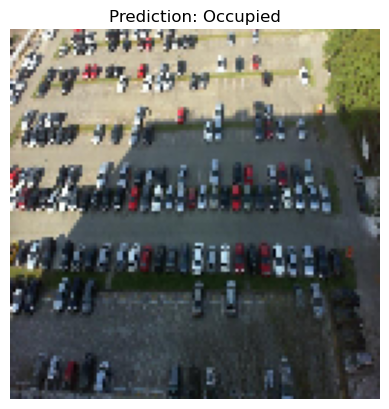

In [30]:
 test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

import matplotlib.pyplot as plt

def visualize_detection(image_path, model):
    img = load_and_preprocess_image(image_path)
    preds = model.predict(np.expand_dims(img, axis=0))
    label = 'Occupied' if np.argmax(preds) == 1 else 'Empty'
    
    plt.imshow(img)
    plt.title(f'Prediction: {label}')
    plt.axis('off')
    plt.show()

visualize_detection(new_image_path, model)